<a href="https://colab.research.google.com/github/Schauhan21/MV/blob/main/MV_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Vision<br>Assignment 1 - Imaging

## Personal details

* **Name:** `SUBAM CHAUHAN`
* **Student ID:** `2771463`

## Introduction

This assignment explores the image processing pipeline of a digital color camera. The goal is to create a color image from the raw sensor readings. The figure below shows the processing steps we need to perform. In this case, the raw image was captured with a smartphone. The raw sensor readings and metadata are saved as a DNG (digital negative) file. DNG is a lossless raw image format that is commonly used in digital photography. For your convenience, the raw image has been converted to NumPy array. The resolution of the original image is 3024 $\times$ 4032 pixels (16-Bit unsigned integer). To speed up the processing, the image has been cropped to 1000 $\times$ 1200 pixels. Before you continue, it is recommended that you go through Lecture 2 and the sample code __[`Imaging.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Imaging.ipynb)__.



<br>

Let us first display the raw sensor image stored in `raw.npy`.

(-0.5, 1199.5, 999.5, -0.5)

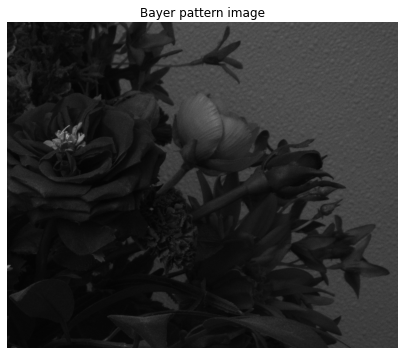

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

bayer = np.load('raw.npy')

plt.figure(figsize=(7,7))
plt.imshow(bayer, cmap='gray')
plt.title('Bayer pattern image')
plt.axis('off')

The image above is quite large so the Bayer filter pattern is not clearly visible. Here we display a smaller image patch.

(-0.5, 49.5, 49.5, -0.5)

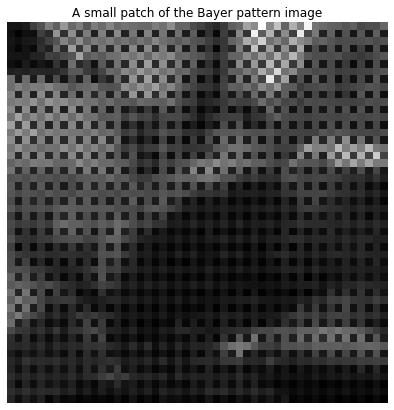

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(bayer[350:400,150:200], cmap='gray')
plt.title('A small patch of the Bayer pattern image')
plt.axis('off')

## 1. Black level adjustment

Pixels that do not receive any light should have zero values. In practice, a dark current signal is still recorded even if the sensor does not receive any light. This leads to a slight offset that should be eliminated. To make sure that very dark regions of an image appear properly black, and that pixel values are in the range $[0,1]$, we can use the formula

$$
I_{bayer\_norm} = \frac{I_{bayer} - b}{w - b}. \qquad (1)
$$

The Bayer pattern image is denoted by $I_{bayer}$. The black level $b$ and white level $w$ are typically stored in the DNG metadata.

**Eliminate the offset and scale** $\quad$ <font color=red>(0.50 points)</font>

Complete the function *adjust_black_level()* in the following code cell. Normalize the raw image named `bayer` using Equation (1) and name the output `bayer_norm`. Make sure that output values are in the range $[0,1]$ by clipping. Use __[**np.clip()**](https://numpy.org/doc/stable/reference/generated/numpy.clip.html)__ similar to the sample code __[`Imaging.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Imaging.ipynb)__. The resulting image should look very similar to the image we already displayed. This is because, by default, *plt.imshow()* maps the lowest value to 0 and the highest to 1.

(-0.5, 1199.5, 999.5, -0.5)

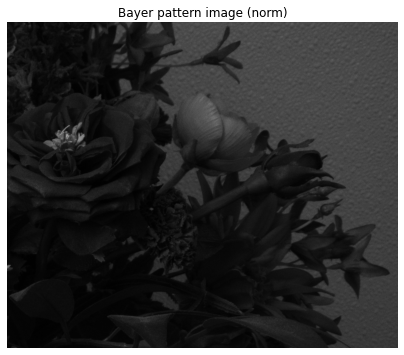

In [ ]:
black_level = 51.5553
white_level = 1023

def adjust_black_level(bayer, black_level, white_level):
    
    # The following line can be removed
    
    # ---------- YOUR CODE STARTS HERE -----------
    bayer_norm = (bayer - black_level) / (white_level - black_level) 
    bayer_norm = np.clip(bayer_norm, 0, 1)
    
    
    
    # ----------- YOUR CODE ENDS HERE ------------
    
    return bayer_norm

bayer_norm = adjust_black_level(bayer, black_level, white_level)

plt.figure(figsize=(7,7))
plt.imshow(bayer_norm, cmap='gray')
plt.title('Bayer pattern image (norm)')
plt.axis('off')

In [ ]:
# LEAVE EMPTY

## 2. White balance

To white balance an image, we need to scale each color channel in the CFA (color filter array) by appropriate amounts. The scale factors are defined in the DNG metadata. The scaling of the green channel (or any other channel) can be set to 1 since only the ratio of the three colors matters. The CFA for the given camera is shown below.




**Perform white balancing** $\quad$ <font color=red>(0.50 points)</font>

Complete the function *white_balance()* in the following code cell. Perform white balancing using the scale factors `wb_coeff`. That is, pixels with red color filter should be multiplied by $1.8028$ and blue pixels by $2.1695$. There is no need to scale green pixels. After white balancing, make sure that values are in the range $[0,1]$ by clipping. Name the output image `bayer_wb` and display it. The image should still look very similar to the previous step.

*Tips*
- Option 1: Familiarize yourself with Python slice notation. For example, to multiply red pixels, you can write `wb_coeff[0]*bayer_norm[::2,::2]`.

- Option 2: Create a 2 $\times$ 2 matrix [R G; G B] from the coefficients. Repeat the matrix vertically  and horizontally to create H $\times$ W white balance mask, where H and W denote the height and width of the image, respectively. This can be done using __[**np.kron()**](https://numpy.org/doc/stable/reference/generated/numpy.kron.html)__ similar to the sample code __[`Imaging.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Imaging.ipynb)__. Then, white balance by multiplying `bayer_norm` with the mask.

(-0.5, 1199.5, 999.5, -0.5)

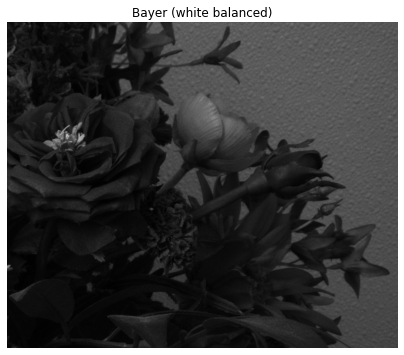

In [ ]:
wb_coeff = np.array([1.8028, 1.0000, 2.1695], dtype=np.float32)

def white_balance(bayer_norm, wb_coeff):

    # The following line can be removed
    
    
    # ---------- YOUR CODE STARTS HERE -----------
    h_x = np.array([[wb_coeff[0], wb_coeff[1]], [wb_coeff[1], wb_coeff[2]]], dtype=np.float32)
    mask = np.kron(np.ones((int((bayer_norm.shape[0]/2)),int(bayer_norm.shape[1]/2))), h_x)
    bayer_wb = bayer_norm * mask
    bayer_wb = np.clip(bayer_wb, 0, 1)
    
    # ----------- YOUR CODE ENDS HERE ------------
    
    return bayer_wb

bayer_wb = white_balance(bayer_norm, wb_coeff)

plt.figure(figsize=(7,7))
plt.imshow(bayer_wb, cmap='gray')
plt.title('Bayer (white balanced)')
plt.axis('off')

In [ ]:
# LEAVE EMPTY

## 3. Demosaicing

Demosaicing techniques make use of pixel's neighborhood to estimate the color values that were not measured. There exist many demosaicing algorithms but here we utilize the one from OpenCV. The output is an RGB image with three channels. The image produced will be in the color space of the camera.

**Run the code below**

Once you have completed previous steps, run the code below. You will see that `cam_rgb` is a color image. However, the image is dark and colors are not quite right.

(-0.5, 1199.5, 999.5, -0.5)

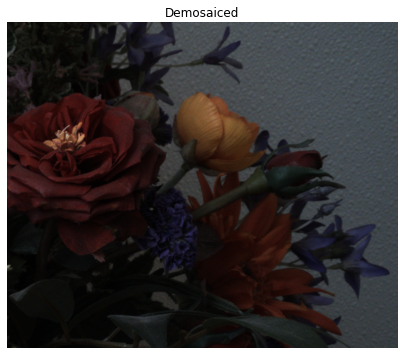

In [ ]:
# Convert to uint16
bayer_uint16 = (65535*bayer_wb).astype(np.uint16)

# Demosaicing (float is not supported)
cam_uint16 = cv2.cvtColor(bayer_uint16, cv2.COLOR_BayerBG2RGB)

# Convert back to float. Range [0,1].
cam_rgb = (cam_uint16/65535).astype(np.float32)

plt.figure(figsize=(7,7))
plt.imshow(cam_rgb)
plt.title('Demosaiced')
plt.axis('off')

## 4. Color space conversions

At the moment, the pixel values are in the camera's color space. We need to apply a linear transformation to convert colors to the CIE XYZ color space. CIE XYZ is a device independent color space. The 3 $\times$ 3 transformation matrix denoted by `cam2xyz` can be obtained from the DNG metadata. We also need to perform another transformation from CIE XYZ color space to the desired output space (sRGB). This transformation matrix is named `xyz2rgb`.

To transform a color to another color space, we multiple the color values with the transformation matrix:

$$
 \begin{pmatrix}
  r \\
  g \\
  b
 \end{pmatrix} = 
 \begin{pmatrix}
  c_{00} & c_{01} & c_{02} \\
  c_{10} & c_{11} & c_{12} \\
  c_{20} & c_{21} & c_{22}
 \end{pmatrix}
 \begin{pmatrix}
  x \\
  y \\
  z
 \end{pmatrix}
$$

In [ ]:
# Transformation matrix (Camera RGB -> CIE XYZ)
cam2xyz = np.array([[0.5533, 0.1456, 0.3011],
                    [0.1905, 0.6709, 0.1386],
                    [-0.0043, -0.2105, 1.2148]])

# Transformation matrix (CIE XYZ -> sRGB)
xyz2rgb = np.array([[3.240479, -1.53715, -0.498535],
                    [-0.969256, 1.875991, 0.041556],
                    [0.055648, -0.204043, 1.057311]])

**4.1. Color transformation** $\quad$ <font color=red>(0.50 points)</font>

Complete the function *convert_colors()* in the following code cell. The function should transform an image from one color space to another. It takes a three channel image and 3 $\times$ 3 transformation matrix as input.

(-0.5, 1199.5, 999.5, -0.5)

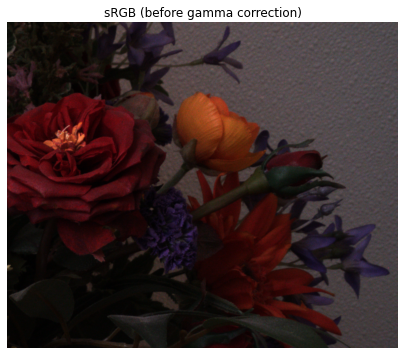

In [ ]:
def convert_colors(img, cmatrix):
    
    # The following line can be removed
    img_cvt = np.zeros_like(img)
    
    # ---------- YOUR CODE STARTS HERE -----------
    a = cmatrix[0,0]*img[:,:,0]+cmatrix[0,1]*img[:,:,1]+cmatrix[0,2]*img[:,:,2]
    b = cmatrix[1,0]*img[:,:,0]+cmatrix[1,1]*img[:,:,1]+cmatrix[1,2]*img[:,:,2]
    c = cmatrix[2,0]*img[:,:,0]+cmatrix[2,1]*img[:,:,1]+cmatrix[2,2]*img[:,:,2] 
    
    img_cvt = np.dstack((a,b,c))
    
    # ----------- YOUR CODE ENDS HERE ------------
    
    return img_cvt

# Here we use the function twice to transform the image to sRGB color space
xyz = convert_colors(cam_rgb, cam2xyz)
srgb = convert_colors(xyz, xyz2rgb)
srgb = np.clip(srgb, 0, 1)

plt.figure(figsize=(7,7))
plt.imshow(srgb)
plt.title('sRGB (before gamma correction)')
plt.axis('off')

In [ ]:
# LEAVE EMPTY

## 5. Gamma correction

Now the image is in the right color space to display. However, the image appears dark since the intensity scale is linear. Humans do not sense brightness on a linear scale. The relationship follows approximately a power function

$$
I_{brightness} = I_{linear}^{\gamma}. \qquad (2)
$$

**Perform gamma correction** $\quad$ <font color=red>(0.50 points)</font>

Complete the following code cell. Use Equation (2) to gamma correct `srgb` image. Set $\gamma=\frac{1}{2.2}$. Name the output `srgb_gamma` and display.

(-0.5, 1199.5, 999.5, -0.5)

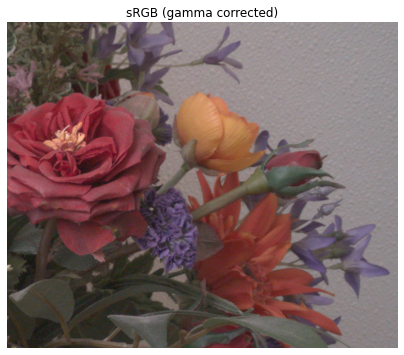

In [ ]:
# ---------- YOUR CODE STARTS HERE -----------
gamma = 1/2.2
srgb_gamma = np.power(srgb, gamma)
srgb_gamma = np.clip(srgb_gamma, 0, 1)

# ----------- YOUR CODE ENDS HERE ------------

plt.figure(figsize=(7,7))
plt.imshow(srgb_gamma)
plt.title('sRGB (gamma corrected)')
plt.axis('off')

In [ ]:
# LEAVE EMPTY

## 6. Further adjustments (optional)

An actual camera pipeline built-in to the device might include various post-processing steps. For example, color artifact removal and edge enhancement are commonly employed. Note also that we skipped a few steps at the beginning of the pipeline, mainly vignetting correction and denoising. The following code improves the appearance of the image by simply increasing the brightness and saturation. Run the code by changing the first line to `if True:`.

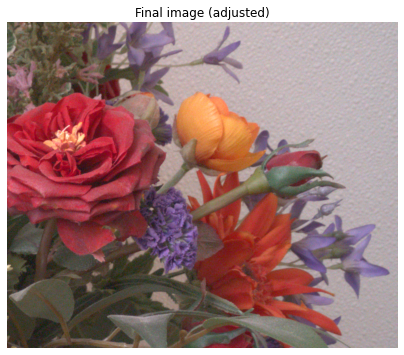

In [ ]:
if True:

    # Increase brightness
    gray = cv2.cvtColor(srgb, cv2.COLOR_RGB2GRAY)
    scaling = 0.25/np.mean(gray.ravel())
    srgb_bright = np.clip(scaling*srgb, 0, 1)
    srgb_bright_gamma = srgb_bright ** (1/2.2)

    # Increase saturation
    hsv = cv2.cvtColor(srgb_bright_gamma, cv2.COLOR_RGB2HSV)
    hsv_adj = hsv.copy()
    hsv_adj[:,:,1] = 1.2*hsv[:,:,1]
    hsv_adj[:,:,1] = np.clip(hsv_adj[:,:,1], 0, 1)
    srgb_adj = cv2.cvtColor(hsv_adj, cv2.COLOR_HSV2RGB)

    plt.figure(figsize=(7,7))
    plt.imshow(srgb_adj)
    plt.title('Final image (adjusted)')
    plt.axis('off')

# Aftermath
Finally, fill your answers to the following questions:

**How much time did you need to complete this exercise?**

`4-5 Hours.`

**Did you experience any problems with the exercise? Was there enough help available? Should this notebook be more (or less) detailed?**

`It took me a while to understand things I was unfamiliar with. I would definetly love more details if available`

# References
`https://numpy.org/doc/stable/reference/generated/numpy.clip.html`
`https://numpy.org/doc/stable/reference/generated/numpy.kron.html`
`https://github.com/jtheikkila/mvis/blob/master/jupyter/Imaging.ipynb`

# Submission

1. Click on the menu `Kernel -> Restart & Clear Output` to clear all outputs and variables, etc.
2. Compress the resulting Jupyter notebook (`MV_A1.ipynb` file) into **`MV_A1_[student number(s)].zip`** (e.g. `MV_A1_1234567.zip` if solo work or `MV_A1_1234567-7654321.zip` if pair work).
3. Upload the .zip file to Moodle. The return box can be found in the assignments section.

**Deadline of the assignment 19.1.2022**